# Project 3

Assignment: "Test whether the data is consistent with racial differences in police use of force."

## Theory

The binary response model assumes that the data generating process is 

$$
\begin{aligned}
y_i^* &= \mathbf{x}_i \boldsymbol{\beta} + u_i, \\ 
y_i   &= \mathbf{1}(y_i^* > 0),
\end{aligned}
$$

where $u_i$ are distributed IID according to some cdf $G$.

In the lectures, we show that 

$$
p_i \equiv \Pr(y_i = 1 \mid \mathbf{x}_i) = G(\mathbf{x}_i \boldsymbol{\beta}).
$$

Since $y_i$ (conditioning on $\mathbf{x}_i$) is Bernoulli-distributed with parameter $p_i$, its log-likelihood function is 

$$
\ell_i(\theta) 
= \mathbf{1}(y_i = 1) \log\!\big[G(\mathbf{x}_i \boldsymbol{\beta})\big]
+ \mathbf{1}(y_i = 0) \log\!\big[1 - G(\mathbf{x}_i \boldsymbol{\beta})\big].
$$

Estimation is then conducted by maximum likelihood,

$$
\hat{\boldsymbol{\theta}} = \arg\max_\theta \frac{1}{N} \sum_{i=1}^N \ell_i (\theta),
$$

which can be implemented as a minimizer in the usual $M$-framework with 
$q(\theta, y_i, x_i) = -\ell_i(\theta)$, and then minimizing 
$Q(\theta) = N^{-1} \sum_i q(\theta, y_i, x_i)$.

We will consider two models in this problem set: 

1. **Probit:** when $G$ is the standard normal CDF (question 2)
2. **Logit:** when $G$ is the standard logistic CDF (question 4)

And we will be comparing them to OLS (which we call the Linear Probability Model, LPM, when $y_i$ is binary).


## Setup 

In [1588]:
# Set path and import packages
from sys import path
import numpy as np
import pandas as pd 
from scipy.stats import norm
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

# Reloads so the kernel won't have to be restarted when changes are made in the other files
%load_ext autoreload
%autoreload 2

# Estimation?
import project3_estimation as est 

# For the linear probability model
import project3_LinearModel as lm

# For probit
import project3_probit

# For logit
import project3_logit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Labor participation of married women

The goal of this week's problem set is to investigate the labor participation of 
married women, using three different types of binary response models.
Binary response models are relevant when the dependent variable $y$ has two possible outcomes, 
e.g., $y=1$ if a person participates in the labor force, and $y=0$ if she does not.
The three models that you are asked to estimate are the Linear Probability Model (LPM), 
the Probit model and the Logit model. 

_Note:_ This week, most of the code has been created for you - you just need to fill in some blanks in the module `NonLinearModel.py`. To estimate the LPM-model using OLS, we will use the code that we have already used in the course, which is in the `LinearModels.py` file, and is preloaded as `lm`.

## 1. Data


In [1589]:
# Inspect data 
dat = pd.read_csv('ppcs_cc.csv')
print(dat.describe())

# Things to note:
 # year is always 2011
 # osplit is always 0
 # 90.4% of observations are involving one or a majority of white officers

            sblack        shisp       swhite       sother        smale  \
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean      0.110555     0.101606     0.739142     0.048697     0.529613   
std       0.313622     0.302169     0.439160     0.215262     0.499188   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     1.000000     0.000000     1.000000   
75%       0.000000     0.000000     1.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              sage        sempl      sincome         spop      daytime  \
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean     41.010003     0.695446     2.164780     1.362727     0.666491   
std      16.146916     0.460279     0.848262     0.765598     0.471529   
min      16.000000     0.000000     1

In [1590]:
# Decide what variables go into the estimation
y = 'anyuseofforce_coded'
x = ['const', 'sblack','shisp','sother','smale', 'sempl','sincome','spop','daytime','inctype_lin','sbehavior','age','omajwhite'] 

In [1591]:
# Load all data
dat = pd.read_csv('ppcs_cc.csv')
print(dat.head())

N = dat.shape[0]

# Create the constant
dat['const'] = np.ones((N,))

# Divede age with 10
dat['age'] = dat['sage']/10



   sblack  shisp  swhite  sother  smale  sage  sempl  sincome  spop  daytime  \
0       1      0       0       0      1    18      0        1     1        1   
1       1      0       0       0      1    20      1        2     4        0   
2       1      0       0       0      1    22      1        2     3        1   
3       1      0       0       0      1    22      1        3     1        1   
4       1      0       0       0      1    22      1        1     1        1   

   inctype_lin  omajblack  omajhisp  omajwhite  omajother  osplit  sbehavior  \
0            2          0         0          1          0       0          0   
1            2          0         0          1          0       0          0   
2            2          0         0          1          0       0          0   
3            2          0         0          1          0       0          0   
4            2          0         0          1          0       0          0   

   year  anyuseofforce_coded  
0  2011

In [1592]:
print(dat['const'])

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3794    1.0
3795    1.0
3796    1.0
3797    1.0
3798    1.0
Name: const, Length: 3799, dtype: float64


In [1593]:
print(dat['age'])

0       1.8
1       2.0
2       2.2
3       2.2
4       2.2
       ... 
3794    7.2
3795    7.1
3796    7.6
3797    7.9
3798    7.5
Name: age, Length: 3799, dtype: float64


In [1594]:
# Reorder columns and keep only the choosen variables
dat = dat[[y] + x].copy()

print(dat.head())

assert dat.notnull().all(axis=1).all(), 'There are missing'

   anyuseofforce_coded  const  sblack  shisp  sother  smale  sempl  sincome  \
0                    0    1.0       1      0       0      1      0        1   
1                    0    1.0       1      0       0      1      1        2   
2                    0    1.0       1      0       0      1      1        2   
3                    0    1.0       1      0       0      1      1        3   
4                    0    1.0       1      0       0      1      1        1   

   spop  daytime  inctype_lin  sbehavior  age  omajwhite  
0     1        1            2          0  1.8          1  
1     4        0            2          0  2.0          1  
2     3        1            2          0  2.2          1  
3     1        1            2          0  2.2          1  
4     1        1            2          0  2.2          1  


In [1595]:
print(dat[x].head())
print(dat[x].describe())

   const  sblack  shisp  sother  smale  sempl  sincome  spop  daytime  \
0    1.0       1      0       0      1      0        1     1        1   
1    1.0       1      0       0      1      1        2     4        0   
2    1.0       1      0       0      1      1        2     3        1   
3    1.0       1      0       0      1      1        3     1        1   
4    1.0       1      0       0      1      1        1     1        1   

   inctype_lin  sbehavior  age  omajwhite  
0            2          0  1.8          1  
1            2          0  2.0          1  
2            2          0  2.2          1  
3            2          0  2.2          1  
4            2          0  2.2          1  
        const       sblack        shisp       sother        smale  \
count  3799.0  3799.000000  3799.000000  3799.000000  3799.000000   
mean      1.0     0.110555     0.101606     0.048697     0.529613   
std       0.0     0.313622     0.302169     0.215262     0.499188   
min       1.0     0.0

In [1596]:
print(dat.head())
print(dat.describe())

   anyuseofforce_coded  const  sblack  shisp  sother  smale  sempl  sincome  \
0                    0    1.0       1      0       0      1      0        1   
1                    0    1.0       1      0       0      1      1        2   
2                    0    1.0       1      0       0      1      1        2   
3                    0    1.0       1      0       0      1      1        3   
4                    0    1.0       1      0       0      1      1        1   

   spop  daytime  inctype_lin  sbehavior  age  omajwhite  
0     1        1            2          0  1.8          1  
1     4        0            2          0  2.0          1  
2     3        1            2          0  2.2          1  
3     1        1            2          0  2.2          1  
4     1        1            2          0  2.2          1  
       anyuseofforce_coded   const       sblack        shisp       sother  \
count          3799.000000  3799.0  3799.000000  3799.000000  3799.000000   
mean             

In [1597]:
y = dat.anyuseofforce_coded.values # .reshape(N,1)
x = dat[x].values
K = x.shape[1]

In [1598]:
# Generate labels
y_label = 'force'

x_label = ['const', 'sblack', 'shisp','sother','smale', 'sempl','sincome','spop','daytime','inctype_lin','sbehavior','age','omajwhite'] 

# 2. Estimate using LPM

In [1599]:
ols_results = lm.estimate(y, x, robust_se=True)
ols_tab = lm.print_table((y_label, x_label), ols_results, title='LPM results')
ols_tab

LPM results
Dependent variable: force

R2 = 0.033
sigma2 = nan


,b_hat,se,t
const,0.0543,0.0291,1.8645
sblack,0.0021,0.0045,0.4630
shisp,0.0091,0.0059,1.5460
sother,-0.0004,0.0058,-0.0631
smale,0.0042,0.0022,1.8891
sempl,-0.0056,0.0031,-1.7904
sincome,0.0010,0.0014,0.7011
spop,0.0041,0.0021,1.9498
daytime,-0.0017,0.0029,-0.5889
inctype_lin,-0.0282,0.0150,-1.8795


# 3. Estimate using probit

The Probit model has the link function 
$$G^{\text{probit}}(\mathbf{x}_i \boldsymbol{\beta}) 
    =\Phi(\mathbf{x}_i \boldsymbol{\beta})
    \equiv \int_{-\infty}^{\mathbf{x}_i \boldsymbol{\beta}}\phi\left(z\right) \, \mathrm{d} z$$

$\phi\left(z\right)= (2 \pi)^{-\frac12}\exp(\frac{-z^{2}}{2})$ is the standard normal pdf. As starting values, we can use OLS estimates: $\boldsymbol{\theta} = \hat{\boldsymbol{\beta}}^{OLS}$. *(Or even better, $2.5\hat{\boldsymbol{\beta}}^{OLS}$, as will become clear later.) 

> Estimate the probit model, filling out the functions `G`, `loglikelihood`, `q`, and `starting_values`. 

***Hints:*** 
* $\Phi(z)$ can be computed with `scipy.stats.norm.cdf(z)`.
* Make sure to keep `theta` "flat", i.e. `theta.ndim == 1`. 

In [1600]:
theta0 = project3_probit.starting_values(y, x)
theta0

array([ 0.13563114,  0.00525683,  0.02274212, -0.00091372,  0.01053204,
       -0.01398951,  0.00238653,  0.01029199, -0.00419631, -0.07057062,
        0.08861737, -0.00391   ,  0.0113545 ])

In [1601]:
ll = project3_probit.loglikelihood(theta0, y, x)

In [1602]:
import numpy as np
np.linalg.matrix_rank(x)


np.int64(13)

In [1603]:
print(x.shape[1])

13


In [1604]:
probit_results = est.estimate(project3_probit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.022591
         Iterations: 85
         Function evaluations: 1302
         Gradient evaluations: 93


In [1605]:
probit_tab = est.print_table(x_label, probit_results, title=f'Probit, y = {y_label}')
probit_tab

Optimizer succeeded after 85 iter. (1302 func. evals.). Final criterion:  0.02259.
Probit, y = force


,theta,se,t
const,-2.2800,1.4492,-1.5733
sblack,0.2406,0.3737,0.6438
shisp,0.4388,0.3024,1.4512
sother,0.0746,0.6325,0.1179
smale,0.5419,0.3832,1.4142
sempl,-0.4126,0.2888,-1.4287
sincome,0.0966,0.1874,0.5153
spop,0.2103,0.1666,1.2623
daytime,-0.1231,0.3058,-0.4027
inctype_lin,-0.7282,0.3246,-2.2438


In [1606]:
# mean value of G(x*theta): 0.46066
# project3_probit.G(x @ probit_results['theta']).mean()

What is the interpretation of $\bar{G(\mathbf{x}\boldsymbol{\beta})}$?

Answer: it is the mean predicted value of labour market participation in this case - on average, less than half of the sample are predicted to be active in the labour market

# 4. Logit
Estimate the logit model with maximum likelihood, using the same explanatory variables as in
**Question 3**.

## The Logit Model

For the Logit model, the link function is 

$$G^{\text{logit}}( \mathbf{x}_i \boldsymbol{\beta} ) = \Lambda(\mathbf{x}_i \boldsymbol{\beta}) \equiv  \frac{\exp(\mathbf{x}_i \boldsymbol{\beta})}{1+\exp(\mathbf{x}_i \boldsymbol{\beta})}= \frac{1}{1+\exp(-\mathbf{x}_i \boldsymbol{\beta})} \tag{2}$$

> Estimate the logit model, filling out the functions `G`, `loglikelihood`, `q`, and `starting_values` in the file `logit.py` so that the code below runs and gives the correct answers. 

In [1607]:
theta0 = project3_logit.starting_values(y, x)
theta0 

array([ 0.21700982,  0.00841092,  0.03638739, -0.00146195,  0.01685126,
       -0.02238322,  0.00381845,  0.01646719, -0.0067141 , -0.11291299,
        0.1417878 , -0.00625601,  0.01816721])

In [1608]:
ll = project3_logit.loglikelihood(theta0, y, x)
np.isclose(np.mean(ll),-0.9974267061091704)

np.False_

In [1609]:
logit_results = est.estimate(project3_logit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.022785
         Iterations: 114
         Function evaluations: 1624
         Gradient evaluations: 116


In [1610]:
logit_tab = est.print_table(x_label, logit_results, title=f'Logit, y = {y_label}')
logit_tab

Optimizer succeeded after 114 iter. (1624 func. evals.). Final criterion:  0.02279.
Logit, y = force


,theta,se,t
const,-4.3478,2.9468,-1.4754
sblack,0.4365,0.9262,0.4713
shisp,0.9483,0.6986,1.3574
sother,-0.2665,1.5367,-0.1735
smale,1.1024,0.8241,1.3377
sempl,-0.9910,0.6245,-1.5870
sincome,0.1917,0.3978,0.4819
spop,0.5423,0.3543,1.5303
daytime,-0.3484,0.6977,-0.4993
inctype_lin,-1.5116,0.7245,-2.0865


# 5. Comparing the raw parameter estimates 

A frequent rule of thumb is that the relationship between the parameter estimates is 
$$
\begin{aligned}
\hat{\boldsymbol{\beta}}_{Logit}&\simeq4\hat{\boldsymbol{\beta}}_{OLS}\\
\hat{\boldsymbol{\beta}}_{Probit}&\simeq2.5\hat{\boldsymbol{\beta}}_{OLS}\\
\hat{\boldsymbol{\beta}}_{Logit}&\simeq1.6\hat{\boldsymbol{\beta}}_{Probit}
\end{aligned}
$$

Test this by calculating the ratios between the estimated coefficients: 
$$\left(\frac{\hat{\boldsymbol{\beta}}_{Logit}}{\hat{\boldsymbol{\beta}}_{OLS}}, \frac{\hat{\boldsymbol{\beta}}_{Probit}}{\hat{\boldsymbol{\beta}}_{OLS}},\frac{\hat{\boldsymbol{\beta}}_{Logit}}{\hat{\boldsymbol{\beta}}_{Probit}} \right)$$

***Hint:*** Parameters are either in the results dictionaries, e.g. `results_probit['theta']`, or in the pandas dataframes, `probit_tab['theta']`. 

In [1611]:
print('Probit / OLS')
print(probit_tab.theta / ols_tab.b_hat)

Probit / OLS
const          -41.988950
sblack         114.571429
shisp           48.219780
sother        -186.500000
smale          129.023810
sempl           73.678571
sincome         96.600000
spop            51.292683
daytime         72.411765
inctype_lin     25.822695
sbehavior       30.028249
age             81.500000
omajwhite      138.155556
dtype: float64


In [1612]:
print('Logit / OLS')
print(logit_tab.theta / ols_tab.b_hat)

Logit / OLS
const          -80.069982
sblack         207.857143
shisp          104.208791
sother         666.250000
smale          262.476190
sempl          176.964286
sincome        191.700000
spop           132.268293
daytime        204.941176
inctype_lin     53.602837
sbehavior       73.248588
age            233.500000
omajwhite      270.177778
dtype: float64


In [1613]:
print('Logit / Probit')
print(logit_tab.theta / probit_tab.theta)

Logit / Probit
const          1.906930
sblack         1.814214
shisp          2.161121
sother        -3.572386
smale          2.034324
sempl          2.401842
sincome        1.984472
spop           2.578697
daytime        2.830219
inctype_lin    2.075803
sbehavior      2.439323
age            2.865031
omajwhite      1.955606
Name: theta, dtype: float64


## 6. Estimating partial effects for sblack, shispanic, sother

The partial (also called marginal) effects in the Logit and Probit
models depend upon the regressors, $x_{k}$. For continuous variables the
partial effects are given as,
$$
\begin{aligned} 
\text{Marginal effect} : \frac{\partial P\left(y_{i}=1\left|\mathbf{x}_i \right.\right)}{\partial x_{ik}}
&=G'(\mathbf{x}_i \boldsymbol{\beta}) 
   \frac{\partial \mathbf{x}_i \boldsymbol{\beta}}{\partial x_{ik}}  \\
&=g(\mathbf{x}_i \boldsymbol{\beta})\beta_{k}
\end{aligned} 
$$
where the derivatives of the CDF, $G'(z) \equiv g(z)$, for the logit and probit models are given by
$$
\begin{aligned} 
g^{\text{logit}}\left(z\right) &= \frac{\exp\left(z\right)}{\left[ 1+\exp\left(z\right)\right] ^2} \\ 
g^{\text{probit}}\left(z\right) &= \phi(z) \equiv \frac{1}{\sqrt{2\pi}}\exp\left(\frac{-z^{2}}{2}\right)
\end{aligned} 
$$



For discrete variables the partial effects are given as,
$$
G\left(\beta_{0}+\beta_{1}x_{1}+\cdots+\beta_{K-1}x_{K-1}+\color{red}{\beta_{K}} \right)-G\left(\beta_{0}+\beta_{1}x_{1}+\cdots+\beta_{K-1}x_{K-1}\right)
$$

where $G$ is either $\Phi$ for the probit model, and $\Lambda$ for the logit.


In [1614]:
# The person we define is average on all parameters but the ones regarding race. Our baseline is a white person.
x_white = np.array([1.0, 0, 0, 0, 1, 1, 2, 1, 1, 2, 0, 4.1, 1]).reshape(1, K) # recall, x_i is a *row* vector
pd.DataFrame(x_white, columns=x_label, index=['x_white']) # print it out 

,const,sblack,shisp,sother,smale,sempl,sincome,spop,daytime,inctype_lin,sbehavior,age,omajwhite
x_white,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,4.1,1.0


In [1615]:
# Estimate the marginal effect of being black
x_black = np.array([1.0, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 4.1, 1]).reshape(1, K) # recall, x_i is a *row* vector
pd.DataFrame(x_black, columns=x_label, index=['x_black']) # print it out 

,const,sblack,shisp,sother,smale,sempl,sincome,spop,daytime,inctype_lin,sbehavior,age,omajwhite
x_black,1.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,4.1,1.0


In [1616]:
k=1
b_pr = probit_tab.theta.values
b_lg = logit_tab.theta.values

In [1617]:
# For probit, calculate the norm.cdf for black = 1, and subtract black = 0
x_black_pr = project3_probit.G(x_black@b_pr) - project3_probit.G(x_white@b_pr) 

# Now for logit
x_black_lg = project3_logit.G(x_black@b_lg) - project3_logit.G(x_white@b_lg)

In [1618]:
# print results 
pd.DataFrame([ols_results['b_hat'][k], 
              x_black_pr[0],
              x_black_lg[0]],
             index=['OLS', 'Probit', 'Logit'], columns=[f'Marg. Eff.: {x_label[k]}']).round(6)

,Marg. Eff.: sblack
OLS,0.002103
Probit,0.000756
Logit,0.000499


In [1619]:
# Now for a hispanic person
x_hisp = np.array([1.0, 0, 1, 0, 1, 1, 2, 1, 1, 2, 0, 4.1, 1]).reshape(1, K) # recall, x_i is a *row* vector
pd.DataFrame(x_hisp, columns=x_label, index=['x_hisp']) # print it out 


,const,sblack,shisp,sother,smale,sempl,sincome,spop,daytime,inctype_lin,sbehavior,age,omajwhite
x_hisp,1.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,4.1,1.0


In [1620]:
m=2

# For probit, calculate the norm.cdf for black = 1, and subtract black = 0
x_hisp_pr = project3_probit.G(x_hisp@b_pr) - project3_probit.G(x_white@b_pr) 

# Now for logit
x_hisp_lg = project3_logit.G(x_hisp@b_lg) - project3_logit.G(x_white@b_lg)


In [1621]:
# print results 
pd.DataFrame([ols_results['b_hat'][k], 
              x_hisp_pr[0],
              x_hisp_lg[0]],
             index=['OLS', 'Probit', 'Logit'], columns=[f'Marg. Eff.: {x_label[m]}']).round(6)

,Marg. Eff.: shisp
OLS,0.002103
Probit,0.001950
Logit,0.001440


## Average partial effect

In [1622]:
import numpy as np

def average_partial_effect(x, beta, k, G):
    """
    Compute the average marginal effect of changing variable k from 0 to 1
    for any model with link function G.

    Parameters
    ----------
    X : np.array, shape (N, K)
        Matrix of covariates.
    beta : np.array, shape (K,)
        Estimated coefficients.
    k : int
        Index of the variable to switch from 0 to 1.
    G : callable
        Link function, e.g. probit or logit CDF. Must take a vector input.

    Returns
    -------
    float
        Average marginal effect of x_k: 0 → 1
    """

    # Copy X twice
    X0 = x.copy()
    X1 = x.copy()

    # Set the variable k to 0 and 1
    X0[:, k] = 0
    X1[:, k] = 1

    # Compute predicted probabilities for each individual
    p0 = G(X0 @ beta)
    p1 = G(X1 @ beta)

    # APE is the average difference
    APE = np.mean(p1 - p0)
    return APE


In [1623]:
ape_probit_black = average_partial_effect(
    x=x,
    beta=b_pr,
    k=1,                     # second variable
    G=project3_probit.G
)

print("Probit APE for variable 1:", ape_probit_black)


Probit APE for variable 1: 0.003214587437753063


In [1624]:
ape_logit_black = average_partial_effect(
    x=x,
    beta=b_lg,
    k=1,                     # second variable
    G=project3_logit.G
)

print("Logit APE for variable 1:", ape_logit_black)


Logit APE for variable 1: 0.002272076735788493


In [1625]:
pd.DataFrame([ols_results['b_hat'][k], 
              ape_probit_black,
              ape_logit_black],
             index=['OLS', 'Probit', 'Logit'], columns=[f'Average Partial Eff.: {x_label[k]}']).round(6)

,Average Partial Eff.: sblack
OLS,0.002103
Probit,0.003215
Logit,0.002272


In [1626]:
ape_probit_hispanic = average_partial_effect(
    x=x,
    beta=b_pr,
    k=2,                     # second variable
    G=project3_probit.G,
)

print("Probit APE for variable 2:", ape_probit_hispanic)


Probit APE for variable 2: 0.006632234694353554


In [1627]:
ape_logit_hispanic = average_partial_effect(
    x=x,
    beta=b_lg,
    k=2,                     # second variable
    G=project3_logit.G
)

print("Logit APE for variable 2:", ape_logit_hispanic)


Logit APE for variable 2: 0.0055788907028284


In [1657]:
pd.DataFrame([ols_results['b_hat'][k], 
              ape_probit_hispanic,
              ape_logit_hispanic],
             index=['OLS', 'Probit', 'Logit'], columns=[f'Average Partial Eff.: {x_label[k]}']).round(6)

,Average Partial Eff.: shisp
OLS,0.009097
Probit,0.006632
Logit,0.005579


# Question 8: Standard errors of the marginal effects with the Delta Method

(This part refers to the material covered in the note, "The Delta Method".) 

Marginal effects are a function of the estimated parameters, $\mathbf{h}(\hat{\theta})$, which is a $K$-vector. The Delta Method tells us how to compute standard errors for $\mathbf{h}(\hat{\boldsymbol{\theta}})$ based on an estimated covariance matrix for $\hat{\boldsymbol{\theta}}$. To do this, define the $K \times K$ matrix of derivatives of $\mathbf{h}$
$$ \mathbf{g} = \nabla_\theta \mathbf{h}(\hat{\boldsymbol{\theta}}).$$

Then we have 
$$ \text{Avar}[\mathbf{h}(\hat{\boldsymbol{\theta}})] = \mathbf{g} \, \text{Avar}(\hat{\boldsymbol{\theta}}) \, \mathbf{g}'$$

## Probit

In the following, you should compute the standard errors for the two marginal effects computed earlier, continuous (education) and discrete (foreign). 

### Continuous case 
From the note, we have 

$$ \mathbf{g} = \phi(\mathbf{x}_0 \hat{\boldsymbol{\beta}}) 
    \left [\mathbf{I}_{K\times K} - (\hat{\boldsymbol{\beta}} \hat{\boldsymbol{\beta}}') (\mathbf{x}_0' \mathbf{x}_0) \right] $$ 

Note that both $\hat{\boldsymbol{\beta}} \hat{\boldsymbol{\beta}}'$ and $\mathbf{x}_0' \mathbf{x}_0$ are $K \times K$ matrices (outer products). 

### Discrete case 

Here, we simply evaluate 
$$ \mathbf{g}_k = \phi(\mathbf{x}_1 \hat{\boldsymbol{\beta}}) \mathbf{x}_1 - \phi(\mathbf{x}_0 \hat{\boldsymbol{\beta}}) \mathbf{x}_0, $$
which is just $1 \times K$ (as $\mathbf{h}$), where the effect is coming only through the changes from $\mathbf{x}_0$ to $\mathbf{x}_1$ (which are subsumed in the notation, but we changed only the `k`th element of `x_me`.)

***Hint:*** Note that $\phi(\mathbf{x}_1 \hat{\boldsymbol{\beta}})$ and $\phi(\mathbf{x}_0 \hat{\boldsymbol{\beta}}) $ are both *scalars*, whereas $\mathbf{x}_0, \mathbf{x}_1$ are $1\times K$ *vectors*. Make sure that you get an $1 \times K$ vector as a result of the products (the choice of `@` vs. `*`). 

## Black (probit)

In [1629]:
def get_se(grad, cov):
    cov_me = grad@cov@grad.T
    return np.sqrt(np.diag(cov_me))


In [1630]:
def grad_black_probit(x, beta, k, G):

    # Copy X twice
    X0 = x.copy()
    X1 = x.copy()

    # Set the variable k to 0 and 1
    X0[:, k] = 0
    X1[:, k] = 1

    # Graduates
    gx0 = norm.pdf(X0 @ beta).reshape(-1, 1)
    gx1 = norm.pdf(X1 @ beta).reshape(-1, 1)

    grad_black_pr = gx1*X1 - gx0*X0

    se_black_pr = get_se(grad_black_pr, probit_results['cov'])

    return grad_black_pr, se_black_pr



In [1631]:
grad_black_pr, se_black_pr = grad_black_probit(x, b_pr, 1, project3_probit.G)


## Hispanic (probit)

In [1632]:
def grad_hispanic_probit(x, beta, k, G):

    # Copy X twice
    X0 = x.copy()
    X1 = x.copy()

    # Set the variable k to 0 and 1
    X0[:, k] = 0
    X1[:, k] = 2

    # Graduates
    gx0 = norm.pdf(X0 @ beta).reshape(-1, 1)
    gx1 = norm.pdf(X1 @ beta).reshape(-1, 1)

    grad_hispanic_pr = gx1*X1 - gx0*X0

    se_hispanic_pr = get_se(grad_hispanic_pr, probit_results['cov'])

    return grad_hispanic_pr, se_hispanic_pr



In [1633]:
grad_hispanic_pr, se_hispanic_pr = grad_hispanic_probit(x, b_pr, 2, project3_logit.G)

In [1634]:
me_dict = {'Marginal Effect': np.vstack([ape_probit_black, ape_probit_hispanic])[:,0],
           's.e.':            np.vstack([se_black_pr, se_hispanic_pr])[:,0]}
tab = pd.DataFrame(me_dict,index=['black=1','hispanic=1'])
tab['t'] = tab['Marginal Effect'] / tab['s.e.']
tab.index.name = 'Var'
tab.round(6)

,Marginal Effect,s.e.,t
Var,,,
black=1,0.003215,0.010685,0.300855
hispanic=1,0.006632,0.103793,0.063899


In [1635]:
def grad_black_logit(x, beta, k, G):

    # Copy X twice
    X0 = x.copy()
    X1 = x.copy()

    # Set the variable k to 0 and 1
    X0[:, k] = 0
    X1[:, k] = 1

    # Graduates
    gx0 = norm.pdf(X0 @ beta).reshape(-1, 1)
    gx1 = norm.pdf(X1 @ beta).reshape(-1, 1)

    grad_black_lg = gx1*X1 - gx0*X0

    se_black_lg = get_se(grad_black_lg, logit_results['cov'])

    return grad_black_lg, se_black_lg


In [1636]:
grad_black_lg, se_black_lg = grad_black_logit(x, b_lg, 1, project3_logit.G)

In [1637]:
def grad_hispanic_logit(x, beta, k, G):

    # Copy X twice
    X0 = x.copy()
    X1 = x.copy()

    # Set the variable k to 0 and 1
    X0[:, k] = 0
    X1[:, k] = 2

    # Graduates
    gx0 = norm.pdf(X0 @ beta).reshape(-1, 1)
    gx1 = norm.pdf(X1 @ beta).reshape(-1, 1)

    grad_hispanic_lg = gx1*X1 - gx0*X0

    se_hispanic_lg = get_se(grad_hispanic_lg, logit_results['cov'])

    return grad_hispanic_lg, se_hispanic_lg


In [1638]:
grad_hispanic_lg, se_hispanic_lg = grad_hispanic_logit(x, b_lg, 2, project3_logit.G)

In [1639]:
me_dict = {'Marginal Effect': np.vstack([ape_logit_black, ape_logit_hispanic])[:,0],
           's.e.':            np.vstack([se_black_lg, se_hispanic_lg])[:,0]}
tab = pd.DataFrame(me_dict,index=['black=1','hispanic=1'])
tab['t'] = tab['Marginal Effect'] / tab['s.e.']
tab.index.name = 'Var'
tab.round(6)

,Marginal Effect,s.e.,t
Var,,,
black=1,0.002272,0.000004,636.097640
hispanic=1,0.005579,0.009052,0.616329


In [1640]:
#bb = np.outer(b_pr,b_pr)
#xx = np.outer(x_white, x_white)
#I_K = np.eye(K)
#gx0 = norm.pdf(x_white@b_pr)
#gx1 = norm.pdf(x_black@b_pr)
#gx2 = norm.pdf(x_hisp@b_pr)

#grad_c_pr = gx0*(np.eye(K) - bb @ xx)
#grad_d_pr1 = gx1*x_black - gx0*x_white
#grad_d_pr2 = gx2*x_hisp - gx0*x_white

In [1641]:
#bb = np.outer(b_pr,b_pr)

In [1642]:
#grad_c_pr.shape == (13,13) # There are 13 right hand side regressors

In [1643]:
#grad_d_pr1.shape == (1,13)

In [1644]:
#grad_d_pr2.shape == (1,13)

In [1645]:
#def get_se(grad, cov):
#    cov_me = grad@cov@grad.T
#    return np.sqrt(np.diag(cov_me))

#se_c_pr = get_se(grad_c_pr, probit_results['cov'])
#se_d_pr1 = get_se(grad_d_pr1, probit_results['cov'])
#se_d_pr2 = get_se(grad_d_pr2, probit_results['cov'])

In [1646]:
#me_dict = {'Marginal Effect': np.vstack([x_black_pr, x_hisp_pr])[:,0],
#           's.e.':            np.vstack([se_d_pr1, se_d_pr2])[:,0]}
#tab = pd.DataFrame(me_dict,index=['black=1', 'hispanic=1'])
#tab['t'] = tab['Marginal Effect'] / tab['s.e.']
#tab.index.name = 'Var'
#tab.round(6)

### Now for logit

In [1647]:
#bb = np.outer(b_lg,b_lg)
#xx = np.outer(x_white, x_white)
#I_K = np.eye(K)
#gx0 = norm.pdf(x_white@b_lg)
#gx1 = norm.pdf(x_black@b_lg)
#gx2 = norm.pdf(x_hisp@b_lg)

#grad_c_lg = gx0*(np.eye(K) - bb @ xx)
#grad_d_lg1 = gx1*x_black - gx0*x_white
#grad_d_lg2 = gx2*x_hisp - gx0*x_white

In [1648]:
#grad_c_lg.shape == (13,13) # There are 13 right hand side regressors

In [1649]:
#grad_d_lg1.shape == (1,13)

In [1650]:
#grad_d_lg2.shape == (1,13)

In [1651]:
#def get_se(grad, cov):
#    cov_me = grad@cov@grad.T
#    return np.sqrt(np.diag(cov_me))

#se_c_lg = get_se(grad_c_lg, logit_results['cov'])
#se_d_lg1 = get_se(grad_d_lg1, logit_results['cov'])
#se_d_lg2 = get_se(grad_d_lg2, logit_results['cov'])

In [1652]:
#me_dict = {'Marginal Effect': np.vstack([x_black_lg, x_hisp_lg])[:,0],
#           's.e.':            np.vstack([se_d_lg1, se_d_lg2])[:,0]}
#tab = pd.DataFrame(me_dict,index=['black=1', 'hispanic=1'])
#tab['t'] = tab['Marginal Effect'] / tab['s.e.']
#tab.index.name = 'Var'
#tab.round(6)

# Bonus Question: Visual comparison

Write the `predict` functions for each of the modules `LinearModel.py`, `probit.py`, `logit.py`, which should implement the following:  
$$ \begin{aligned} 
\text{OLS} : \hat{y}_i &= \mathbf{x}_i \hat{\boldsymbol{\beta}}^{\text{OLS}} \\ 
\text{Probit} : \hat{y}_i &= \Phi(\mathbf{x}_i \hat{\boldsymbol{\beta}}^{\text{Probit}} ) \\ 
\text{Logit} : \hat{y}_i &= \frac{1}{1 + \exp(-\mathbf{x}_i \hat{\boldsymbol{\beta}}^{\text{Logit}})} 
\end{aligned}
$$

In [1653]:
#assert np.isclose(np.mean(lm.predict(ols_results['b_hat'],            x)), 0)
#assert np.isclose(np.mean(project3_probit.predict(probit_results['theta'], x)), 0)
#assert np.isclose(np.mean(project3_logit.predict(logit_results['theta'],   x)), 0)

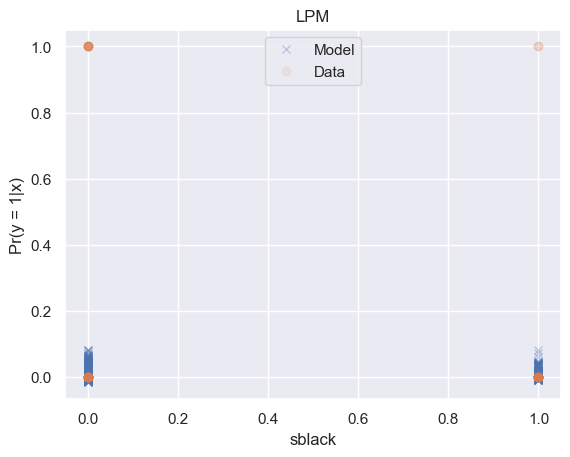

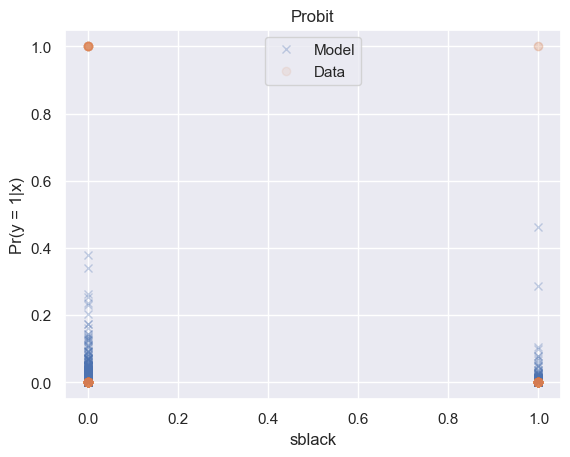

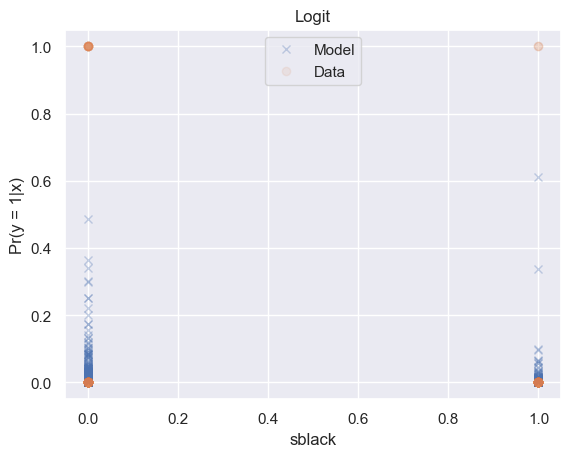

In [1654]:
def plot_fit(theta, yhat, y, x, k:int, title=None): 
    '''plot_fit(): plot the predictions, f_predict(theta,x), from the model against the data
    Args. 
        theta: array of parameters, 
        yhat: fitted values 
        y: actual outcome 
        x: regressors 
        k: index for the regressor, x[:,k], to put on the x axis 
    '''
    
    fig, ax = plt.subplots(); 
    ax.plot(x[:,k], yhat, 'x', alpha=0.3, label='Model'); 
    ax.plot(x[:,k], y,    'o', alpha=0.1, label='Data')
    
    # nicify 
    ax.set_xlabel(x_label[k]); 
    ax.set_ylabel('Pr(y = 1|x)')
    ax.set_title(title)
    ax.legend()

k = 1 # which variable to put on the x-axis 

yhatO = lm.predict(ols_results['b_hat'], x)
plot_fit(ols_results['b_hat'], yhatO, y, x, k, 'LPM')

yhatP = project3_probit.predict(probit_results['theta'], x)
plot_fit(probit_results['theta'], yhatP, y, x, k, 'Probit')

yhatL = project3_logit.predict(logit_results['theta'], x)
plot_fit(logit_results['theta'], yhatL, y, x, k, 'Logit')

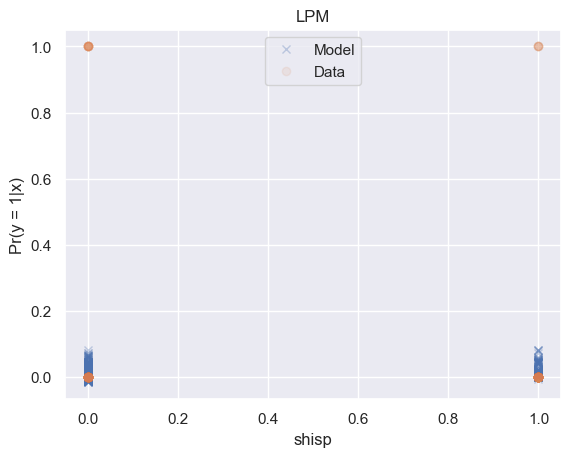

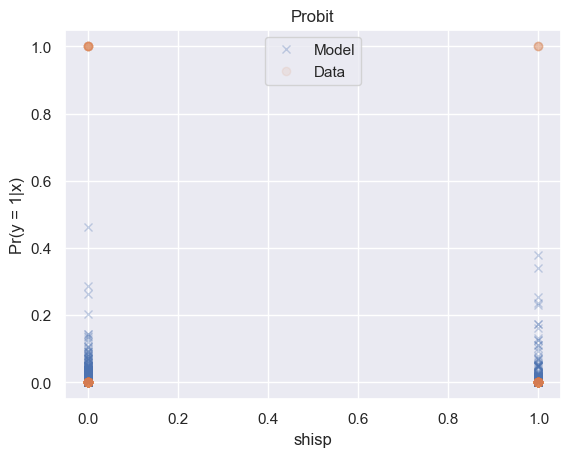

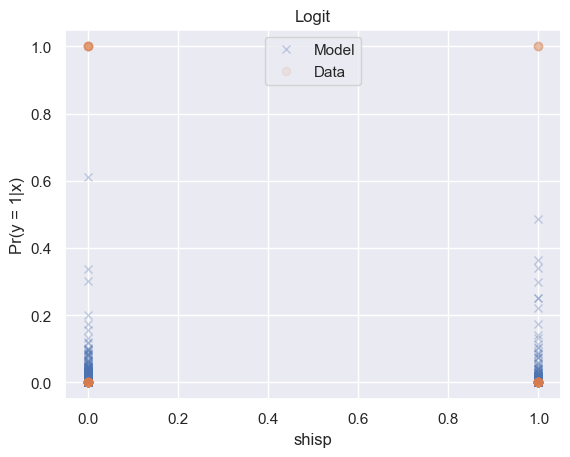

In [1655]:
def plot_fit(theta, yhat, y, x, k:int, title=None): 
    '''plot_fit(): plot the predictions, f_predict(theta,x), from the model against the data
    Args. 
        theta: array of parameters, 
        yhat: fitted values 
        y: actual outcome 
        x: regressors 
        k: index for the regressor, x[:,k], to put on the x axis 
    '''
    
    fig, ax = plt.subplots(); 
    ax.plot(x[:,k], yhat, 'x', alpha=0.3, label='Model'); 
    ax.plot(x[:,k], y,    'o', alpha=0.1, label='Data')
    
    # nicify 
    ax.set_xlabel(x_label[k]); 
    ax.set_ylabel('Pr(y = 1|x)')
    ax.set_title(title)
    ax.legend()

k = 2 # which variable to put on the x-axis 

yhatO = lm.predict(ols_results['b_hat'], x)
plot_fit(ols_results['b_hat'], yhatO, y, x, k, 'LPM')

yhatP = project3_probit.predict(probit_results['theta'], x)
plot_fit(probit_results['theta'], yhatP, y, x, k, 'Probit')

yhatL = project3_logit.predict(logit_results['theta'], x)
plot_fit(logit_results['theta'], yhatL, y, x, k, 'Logit')